In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def nonlinear_generator(
    sample_size = 500,
    effect = 0.5,
    t_proportion = 0.5,
    x_coef = 0.75,
    seed = 123,
):
    rng = np.random.default_rng(seed=seed)
    x = rng.uniform(low=-10, high=10, size = (sample_size,))
    t = rng.binomial(n=1, p=t_proportion, size=(sample_size,))
    xt = x_coef*(x**2/20-0.2)*(x/5)
    y = effect*t + xt + rng.normal(scale = 1, size=(sample_size,))
    x_centered = x - np.mean(x)

    data = pd.DataFrame(
        {
            "Y" : y,
            "X" : x,
            "X_centered" : x_centered,
            "T" : t
        }
    )
    return data

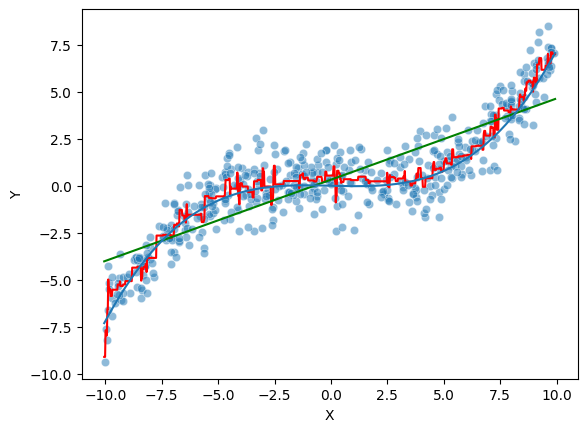

In [3]:
rng = np.random.default_rng(seed = 123)
data = nonlinear_generator()

g = GradientBoostingRegressor().fit(data[['X']].to_numpy(), data['Y'].to_numpy())
reg = LinearRegression().fit(data[['X']].to_numpy(), data['Y'].to_numpy())

xgrid = np.linspace(
    start = np.min(data['X'])-0.05,
    stop = np.max(data['X']+0.05),
    num=1000).reshape(-1,1)

gpreds = g.predict(xgrid)
rpreds = reg.predict(xgrid)

sns.scatterplot(x=data['X'], y=data['Y'], alpha=0.5)
plt.plot(xgrid, gpreds, color='red')
plt.plot(xgrid, rpreds, color='green')
plt.plot(xgrid, c*(xgrid**2/20-0.2)*(xgrid/5))

In [4]:
reg = smf.ols(
    "Y ~ T",
    data = data
).fit(cov_type='HC2')
reg.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
No. Observations:                 500   F-statistic:                     8.990
Covariance Type:                  HC2   Prob (F-statistic):            0.00285
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0665      0.191     -0.348      0.728      -0.441       0.308
T              0.7846      0.262      2.998      0.003       0.272       1.297
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [5]:
reg = smf.ols(
    "Y ~ T + X + X_centered:T",
    data = data
).fit(cov_type='HC2')
reg.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
No. Observations:                 500   F-statistic:                     382.1
Covariance Type:                  HC2   Prob (F-statistic):          1.63e-128
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0078      0.102      0.076      0.939      -0.193       0.208
T                0.6030      0.138      4.384      0.000       0.333       0.873
X                0.4265      0.019     22.099      0.000       0.389       0.464
X_centered:T     0.0069      0.026      0.263      0.792      -0.044       0.058
================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [ ]:
def mlrate_df(
    data,
    model,
    n_splits = 2
):
    kf = KFold(
        n_splits = n_splits, 
        shuffle=True)
    kf.get_n_splits(data)
    final = data.copy()
    combined = np.zeros(data.shape[0])
    for i, (train_idx, test_idx) in enumerate(kf.split(data)):
        train = data.loc[train_idx]
        test = data.loc[test_idx]
        g = model.fit(train[['X']].to_numpy(), train['Y'].to_numpy())
        gpreds = g.predict(test[['X']].to_numpy())
        combined[test_idx] = gpreds

    final["G"] = combined
    final["G_centered"] = combined - np.mean(combined)

    return final

In [6]:
kf = KFold(
    n_splits = 2, 
    shuffle=True)
kf.get_n_splits(data)
final = data.copy()
combined = np.zeros(data.shape[0])
for i, (train_idx, test_idx) in enumerate(kf.split(data)):
    train = data.loc[train_idx]
    test = data.loc[test_idx]
    g = GradientBoostingRegressor().fit(train[['X']].to_numpy(), train['Y'].to_numpy())
    gpreds = g.predict(test[['X']].to_numpy())
    combined[test_idx] = gpreds

final["G"] = combined
final["G_centered"] = combined - np.mean(combined)
reg = smf.ols(
    "Y ~ T + G + T:G_centered",
    data = final
).fit(cov_type="HC2")
reg.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
No. Observations:                 500   F-statistic:                     1072.
Covariance Type:                  HC2   Prob (F-statistic):          2.88e-216
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2051      0.075     -2.726      0.006      -0.352      -0.058
T                0.4302      0.103      4.197      0.000       0.229       0.631
G                0.9586      0.025     38.169      0.000       0.909       1.008
T:G_centered     0.0075      0.035      0.216      0.829      -0.060       0.075
================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [7]:
est = []
for i in range(1000):
    seed = rng.integers(low=0, high = 100000)
    data_trial = nonlinear_generator(
        seed=seed,
        x_coef = 0.75)
    reg = smf.ols(
        "Y ~ T",
        data = data_trial
    ).fit(cov_type='HC2')
    est.append(reg.params['T'])

print(np.mean(est))
print(np.min(est), np.max(est))

0.500346342325615
-0.5661343561465675 1.3195177370513491


In [8]:
est = []
for i in range(1000):
    seed = rng.integers(low=0, high = 100000)
    data_trial = nonlinear_generator(
        seed=seed,
        x_coef = 0.75)
    reg = smf.ols(
        "Y ~ X + T + X_centered:T",
        data = data_trial
    ).fit(cov_type='HC2')
    est.append(reg.params['T'])

print(np.mean(est))
print(np.min(est), np.max(est))

0.49938046766088695
0.11665402346626817 0.9320170555812088


In [9]:
est = []
for i in range(1000):
    seed = rng.integers(low=0, high = 100000)
    data_trial = nonlinear_generator(
        seed=seed,
        sample_size=500,
        x_coef = 0.75)
    kf = KFold(
        n_splits = 2, 
        shuffle=True)
    kf.get_n_splits(data_trial)
    estimates = []
    sd = []
    final = data_trial.copy()
    combined = np.zeros(data_trial.shape[0])
    for i, (train_idx, test_idx) in enumerate(kf.split(data_trial)):
        train = data_trial.loc[train_idx]
        test = data_trial.loc[test_idx]
        g = GradientBoostingRegressor().fit(train[['X']].to_numpy(), train['Y'].to_numpy())
        gpreds = g.predict(test[['X']].to_numpy())
        combined[test_idx] = gpreds

    final["G"] = combined
    final["G_centered"] = combined - np.mean(combined)
    reg = smf.ols(
        "Y ~ T + G + T:G_centered",
        data = final
    ).fit(cov_type="HC2")
    est.append(reg.params['T'])

print(np.mean(est))
print(np.min(est), np.max(est))

0.5092553159187551
0.25580965086645197 0.8236393733290679
